In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.insert(0,'/content/drive/')
import os

# TODO: Fill in the Google Drive path where you uploaded the files 
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab/final_project/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['COVID_combined', 'Normal', 'maskHE2_labels.csv', 'test', 'validation', 'ReadMe.gdoc', 'training.ipynb', 'training', 'train_dataset.npy', 'valid_dataset.npy', 'train_dataset_jiahong.npy', 'valid_dataset_jiahong.npy', 'Model_LungSegmentation', 'Model_Without_Lungseg', 'images_nomask', 'HE_output2.zip', 'Things to be done for Final Project.gdoc', 'Siamese_Learning.ipynb', 'grad_labels.csv', 'Matching_code', 'val_labels.csv', 'test_labels.csv', 'train_labels.csv', 'Copy of Siamese_Learning.ipynb', 'COVID-19 X-Ray Image Classification Using Transfer Learning and Contrastive Learning.gslides', 'Training_VGG16_CrossValidation_WithLungMasking.ipynb', 'grad_labels_4.csv', 'grad_labels_new.csv', 'create_label.ipynb']


In [3]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from skimage import io, transform
from PIL import Image

import copy

**Transform dataset- Data Augmentation**

In [4]:
train_transforms = transforms.Compose([
            transforms.RandomRotation(30),
            transforms.CenterCrop(299),   #I thing CenterCrop makes more sense than randomCrop, because the lung is ususally at the center of the image
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])  #used for data augmentation

val_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(299),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

# test_transforms = transforms.Compose([
#             transforms.Resize(256),
#             transforms.CenterCrop(299),
#             transforms.ToTensor(),
#             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#         ])

test_transforms = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

train_csv = os.path.join(GOOGLE_DRIVE_PATH,'train_labels.csv')
val_csv = os.path.join(GOOGLE_DRIVE_PATH,'val_labels.csv')
test_csv = os.path.join(GOOGLE_DRIVE_PATH,'test_labels.csv')
grad_csv = os.path.join(GOOGLE_DRIVE_PATH,'grad_labels.csv')

grad_csv_4 = os.path.join(GOOGLE_DRIVE_PATH,'grad_labels_new.csv')

class_numbers = 2

COVID_path = os.path.join(GOOGLE_DRIVE_PATH,"images_nomask/COVID")
Normal_path = os.path.join(GOOGLE_DRIVE_PATH,"images_nomask/Normal")

batch_size = 32

**adding the Kfold**

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [6]:
train_df1 = pd.read_csv(train_csv)
train_df2 = pd.read_csv(val_csv)
train_df=train_df2.append(train_df1,ignore_index=True,sort=True)
#print(train_df)

test_df = pd.read_csv(test_csv)
#print(test_df)

grad_df = pd.read_csv(grad_csv)

grad_df_4 = pd.read_csv(grad_csv_4)

In [ ]:
train_features=train_df['Images']
train_target=train_df['encoded_labels']
n_splits = 10 # Number of K-fold Splits

splits = list(StratifiedKFold(n_splits=n_splits, shuffle=True).split(train_features, train_target))
splits

**Inception_V3**

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = models.inception_v3(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False
num_ftrs = model_ft.AuxLogits.fc.in_features
model_ft.AuxLogits.fc = nn.Linear(num_ftrs, 2)
# Handle the primary net
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft.aux_logits=False
model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [8]:
params_to_update = []
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

**Dataloader Function For Cross validation-Training**

In [14]:
class CovidDataset_Train(Dataset):  # 0 stands for Covid and 1 stands for Normal

  def __init__(self, pandas_file,root_dir1, root_dir,transform=None):
    self.XRay_image = pandas_file
    self.root_dir = root_dir
    self.root_dir1 = root_dir1
    self.transform = transform

  def __len__(self):
    return len(self.XRay_image)

  def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name1 = os.path.join(self.root_dir, self.XRay_image.iloc[idx,0])
        img_name2 = os.path.join(self.root_dir1, self.XRay_image.iloc[idx,0])
        if os.path.exists(img_name1):
          true_name=img_name1
        else:
          true_name=img_name2

        image = io.imread(true_name) # the origial image has 3 channels
        #print(image.shape)
        #image = np.expand_dims(image,axis = 2) #(512,512) but the input of VGG should have three channels
        #image = np.repeat(image, 3, axis=2) #(512, 512, 3)

        image = Image.fromarray(image, 'RGB') # change to PIL image inorder to use transformation
        label = int(self.XRay_image.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        sample = (image, label)
        return sample

**Training With Cross Validation**

In [ ]:
num_epochs = 10 # it will multiple with 5 bc of cross validation
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(params_to_update, lr=0.002, momentum=0.9)
optimizer = optim.Adam(params_to_update, lr=0.001)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)


In [ ]:
since = time.time()
model=model_ft
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

train_acc_history  = []
val_acc_history = []
train_loss_history = []
avg_losses_f = []
avg_val_losses_f = []


#load train data
for i, (train_idx, valid_idx) in enumerate(splits): 

  print('K-Fold {}/{}'.format(i, n_splits - 1))
  print('-' * 10)  

  Label=train_df['encoded_labels'][train_idx.astype(int)].to_numpy()
  pandas_file=train_df['Images'][train_idx.astype(int)].to_numpy()
  Train_Final_pd=pd.DataFrame({'x':pandas_file,'y':Label})
  Train_loader=CovidDataset_Train(pandas_file=Train_Final_pd, root_dir1=COVID_path, root_dir = Normal_path,transform=train_transforms)

  Label_Valid=train_df['encoded_labels'][valid_idx.astype(int)].to_numpy()
  pandas_file_Valid=train_df['Images'][valid_idx.astype(int)].to_numpy()
  Valid_Final_pd=pd.DataFrame({'x':pandas_file_Valid,'y':Label_Valid})
  Valid_loader=CovidDataset_Train(pandas_file=Valid_Final_pd, root_dir1=COVID_path,root_dir= Normal_path,transform=val_transforms)


  dataloaders ={"train":torch.utils.data.DataLoader(Train_loader, batch_size=batch_size, shuffle=True), 
             "val":torch.utils.data.DataLoader(Valid_loader, batch_size=batch_size, shuffle=True) }
  dataset_sizes = {"train":len(Train_loader), "val": len(Valid_loader)}

  for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
          if phase == 'train':
                model.train()  # Set model to training mode
          else:
                model.eval()
          running_loss = 0.0
          running_corrects = 0
          idx = 0
          for inputs, labels in dataloaders[phase]:
                idx = idx + 1
                inputs = inputs.to(device)
                labels = labels.to(device)
                #print("processing data: ", idx)

                # zero the parameter gradients
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += float(loss.item() * inputs.size(0))
                running_corrects += torch.sum(preds == labels.data)
          #if phase == 'train':
                #scheduler.step()

          epoch_loss = float(running_loss / dataset_sizes[phase])
          epoch_acc = float(running_corrects.double() / dataset_sizes[phase])

          if phase == 'train':
                scheduler.step(epoch_loss)

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
          if phase=="train":

              train_acc_history.append(epoch_acc)
              train_loss_history.append(epoch_loss)
          if phase =='val':
              val_acc_history.append(epoch_acc)
              if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # save the best model
                torch.save(best_model_wts, GOOGLE_DRIVE_PATH+'Model_Without_Lungseg/InceptionV3_Cross_Validation_nomask.pt')

        print()
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
  time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
  model.load_state_dict(best_model_wts)



K-Fold 0/9
----------
Epoch 0/9
----------
train Loss: 0.5165 Acc: 0.7484
val Loss: 0.4267 Acc: 0.8310

Epoch 1/9
----------
train Loss: 0.4269 Acc: 0.8054
val Loss: 0.3832 Acc: 0.8495

Epoch 2/9
----------
train Loss: 0.4134 Acc: 0.8112
val Loss: 0.3849 Acc: 0.8264

Epoch 3/9
----------
train Loss: 0.3882 Acc: 0.8240
val Loss: 0.3662 Acc: 0.8402

Epoch 4/9
----------
train Loss: 0.3892 Acc: 0.8242
val Loss: 0.3606 Acc: 0.8602

Epoch 5/9
----------
train Loss: 0.4015 Acc: 0.8148
val Loss: 0.3407 Acc: 0.8664

Epoch 6/9
----------
train Loss: 0.3893 Acc: 0.8250
val Loss: 0.3366 Acc: 0.8740

Epoch 7/9
----------
train Loss: 0.3808 Acc: 0.8291
val Loss: 0.3313 Acc: 0.8602

Epoch 8/9
----------
train Loss: 0.3844 Acc: 0.8272
val Loss: 0.3388 Acc: 0.8525

Epoch 9/9
----------
train Loss: 0.3823 Acc: 0.8242
val Loss: 0.3392 Acc: 0.8571

Training complete in 27m 33s
Best val Acc: 0.874040
K-Fold 1/9
----------
Epoch 0/9
----------
train Loss: 0.3769 Acc: 0.8320
val Loss: 0.3507 Acc: 0.8449

Ep

**The best model has been saved during the training**

In [ ]:

#Don't forget to download the Weights

#torch.save(best_model_wts, GOOGLE_DRIVE_PATH+'Model_Without_Lungseg/InceptionV3_Cross_Validation_nomask.pt')
#from google.colab import files
#files.download('InceptionV3_Cross_Validation.pt') 

**Save the training history**

In [ ]:
SAVE_PATH = GOOGLE_DRIVE_PATH+'Model_Without_Lungseg/'
torch.save({
            'num_epochs': num_epochs,
            'val_acc_history': val_acc_history,
            'train_acc_history': train_acc_history,
            'train_loss': train_loss_history,
            }, SAVE_PATH+'InV3_nomask_train_history.pt')

**Visulization_Result**

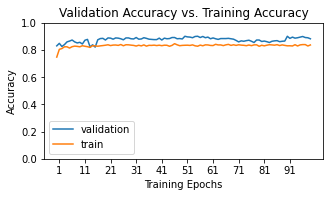

In [ ]:
plt.figure(figsize=(5,2.5)) 
plt.title("Validation Accuracy vs. Training Accuracy")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(len(val_acc_history)),val_acc_history,label="validation")
plt.plot(range(len(val_acc_history)),train_acc_history,label="train")
plt.ylim((0,1.))
plt.xticks(np.arange(1, len(val_acc_history)+1, 10))
plt.legend()
plt.show()

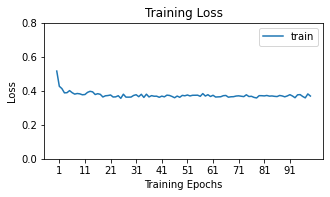

In [ ]:
plt.figure(figsize=(5,2.5)) 
plt.title("Training Loss")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(len(val_acc_history)),train_loss_history,label="train")
plt.ylim((0,0.8))
plt.xticks(np.arange(1, len(val_acc_history)+1, 10))
plt.legend()
plt.show()

**Test**

In [15]:
#load the trianed model
model_ft.load_state_dict(torch.load(GOOGLE_DRIVE_PATH + 'Model_Without_Lungseg/InceptionV3_Cross_Validation_nomask.pt',map_location=torch.device('cpu')))
model_ft.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
#load test data

Label=test_df['encoded_labels'].to_numpy()
pandas_file=test_df['Images'].to_numpy()
Test_Final_pd=pd.DataFrame({'x':pandas_file,'y':Label})
Test_loader=CovidDataset_Train(pandas_file=Test_Final_pd, root_dir1=COVID_path, root_dir = Normal_path, transform=test_transforms)

test_dataloader = torch.utils.data.DataLoader(Test_loader, shuffle=True)
#print(len(Test_loader))  #732

result=[]
running_corrects=0
for inputs, labels in test_dataloader:
  inputs = inputs.to(device)
  labels = labels.to(device)
  outputs = model_ft(inputs)
  _, preds = torch.max(outputs, 1)
  running_corrects += torch.sum(preds == labels)
  result.append(np.array(preds.detach().cpu(),dtype='float32'))

In [ ]:
# from scipy.io import savemat

# mdic = {"Result": np.asarray(result)}
# savemat(SAVE_PATH + "InceptionV3_Test_Index_nomask.mat", mdic)

In [ ]:
epoch_acc = float(running_corrects.double()/len(Test_loader))
print(epoch_acc)

0.8423236514522822


**Grad-CAM**

reference: https://www.kaggle.com/bonhart/inceptionv3-tta-grad-cam-pytorch

In [16]:
#load test data
Label=grad_df_4['encoded_labels'].to_numpy()
pandas_file=grad_df_4['Images'].to_numpy()
Grad_Final_pd=pd.DataFrame({'x':pandas_file,'y':Label})
Grad_loader=CovidDataset_Train(pandas_file=Grad_Final_pd, root_dir1=COVID_path, root_dir = Normal_path, transform=test_transforms)
grad_dataloader = torch.utils.data.DataLoader(Grad_loader, batch_size = 1, shuffle=False)

dataloader_iter = iter(grad_dataloader)


#get the image from the dataloader
#img, labels = next(iter(test_dataloader))
#img = img.to(device)

In [17]:
# Extract  pretrained activations
class SaveFeatures():
    """ Extract pretrained activations"""
    features=None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self):
        self.hook.remove()

print(type(model_ft))    
#final_layer = model_ft._modules.get('features')[10]['denselayer16']  #get the layer of features ->denseblock4 ->denselayer16

final_layer = model_ft._modules.get('Mixed_7c')#get the layer before fc 
activated_features = SaveFeatures(final_layer)

<class 'torchvision.models.inception.Inception3'>


In [18]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    weight = np.expand_dims(weight_fc[class_idx], axis = 0)
    cam = weight.dot(feature_conv[0,:, :, :].reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return cam_img

weight_softmax_params = list(model_ft._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
weight_softmax_params[0]

Parameter containing:
tensor([[ 0.0210,  0.0091, -0.0292,  ...,  0.0079,  0.0320,  0.0361],
        [-0.0498, -0.0250,  0.0342,  ..., -0.0242, -0.0389, -0.0083]],
       device='cuda:0', requires_grad=True)

In [19]:
proba = []
heatmaps = []
original_images = []
predict_labels = []
gt_labels = []

for i in range(4):
  img, labels = next(dataloader_iter)
  img = img.to(device)
  output = model_ft(img)
  probabilities = F.softmax(output,dim=1).data.squeeze()
  proba.append((str(np.round(np.max(probabilities.cpu().detach().numpy())*100,2)))+'%')

  pred_idx = np.argmax(probabilities.cpu().detach().numpy(),axis=0)
  predict_labels.append(pred_idx)
  gt_labels.append(labels)

  cur_images = img.cpu().numpy().transpose((0, 2, 3, 1))

  original_images.append(cur_images)

  grad_img = getCAM(activated_features.features, weight_softmax, pred_idx)
  #activated_features.remove()
  heatmaps.append(grad_img)
    
print(len(proba), len(heatmaps),len(predict_labels))
print(proba)
print(predict_labels)
print(gt_labels)


4 4 4
['75.51%', '99.0%', '64.59%', '84.99%']
[0, 0, 1, 1]
[tensor([0]), tensor([0]), tensor([1]), tensor([1])]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


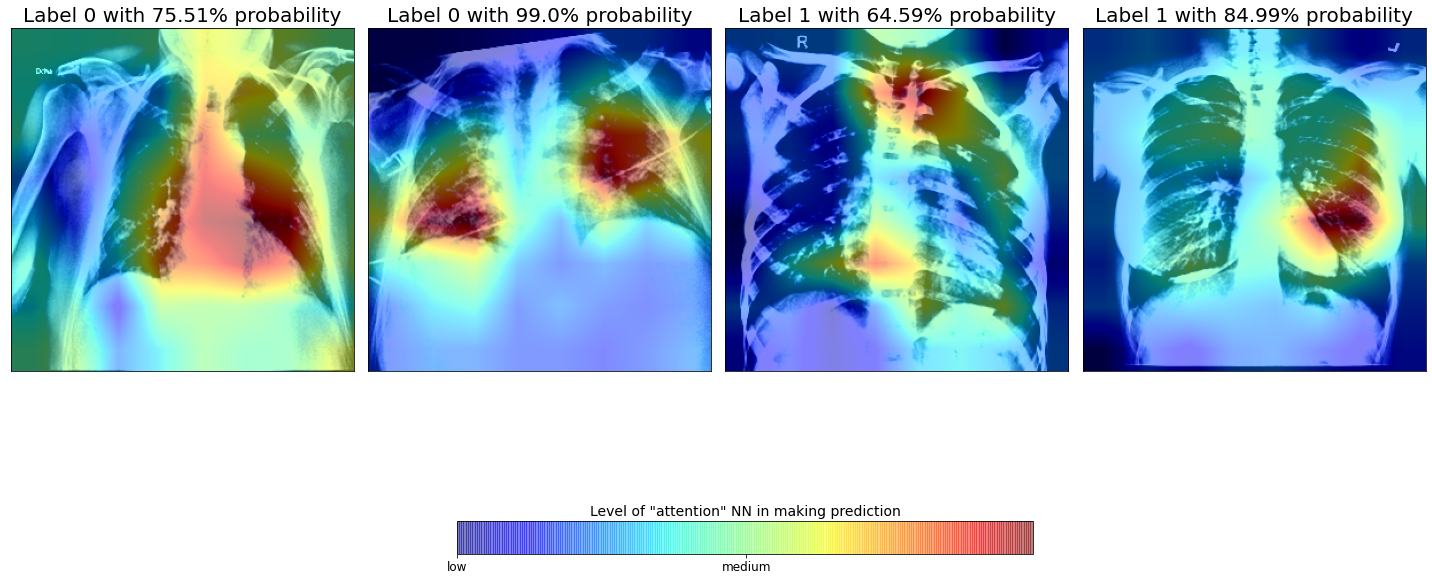

In [20]:
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
fig=plt.figure(figsize=(20,15))


for i in range(0, len(original_images)):
    img = original_images[i]
    mask = heatmaps[i]
    ax = fig.add_subplot(2, 4,i +1,xticks=[], yticks=[])
    fig.tight_layout()
    plt.imshow(img[0,:,:,:])
    plt.imshow(cv2.resize(mask, (299,299), interpolation=cv2.INTER_LINEAR), alpha=0.5, cmap='jet');
    ax.set_title('Label %d with %s probability' % (predict_labels[i], proba[i]),fontsize=20)
    #ax.set_title('Label %d ' % (predict_labels[i]),fontsize=12)
    
#cax = fig.add_axes([0.3, 0.42, 0.4, 0.04]) # place where be map
cax = fig.add_axes([0.32, 0.42, 0.4, 0.03]) # place where be map
clb = plt.colorbar(cax=cax, orientation='horizontal',ticks=[0, 0.5, 1])
clb.ax.set_title('Level of "attention" NN in making prediction',fontsize=14)
clb.ax.set_xticklabels(['low', 'medium', 'high'],fontsize=12)

plt.show()

**Grad-CAM2**

In [ ]:
#load the trianed model
model_ft.load_state_dict(torch.load(GOOGLE_DRIVE_PATH + 'Model_Without_Lungseg/InceptionV3_Cross_Validation_nomask.pt',map_location=torch.device('cpu')))
model_ft.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
#load test data
Label=grad_df['encoded_labels'].to_numpy()
pandas_file=grad_df['Images'].to_numpy()
Grad_Final_pd=pd.DataFrame({'x':pandas_file,'y':Label})
Grad_loader=CovidDataset_Train(pandas_file=Grad_Final_pd, root_dir1=COVID_path, root_dir = Normal_path, transform=test_transforms)
grad_dataloader = torch.utils.data.DataLoader(Grad_loader, batch_size = 1, shuffle=False)

dataloader_iter = iter(grad_dataloader)

In [ ]:
# Extract  pretrained activations
class SaveFeatures():
    """ Extract pretrained activations"""
    features=None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self):
        self.hook.remove()
  
class SaveGradients():
    features=None
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, grad_input, grad_output):
        print(grad_output)
        self.features = ((grad_output.detach().cpu()).data).numpy()
        print("------------------")
        print(self.features)
    def remove(self):
        self.hook.remove()

final_layer = model_ft.Mixed_7c.branch_pool.bn
#final_layer = model_ft._modules.get('avgpool')
#final_layer = vgg16._modules.get('features')[29] #get the layer before fc 
#print(final_layer)
activated_features = SaveFeatures(final_layer)
activated_gradients = SaveGradients(final_layer)

print(activated_gradients)

In [ ]:
def cam_img(feature_map, grads):
    _, nc, h, w = feature_map.shape
    cam = np.zeros((h,w), dtype=np.float32)	
    #print(cam.shape)
    grads = grads[0]
    #print(grads.shape)	
    weights = np.mean(grads, axis=(1,2))
    #print(weights.shape)
    for i, w in enumerate(weights):
        cam += w * feature_map[0, i, :, :]
    #print(cam.shape)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()

    return cam

In [ ]:

proba = []
heatmaps = []
original_images = []
predict_labels = []
gt_labels = []

for i in range(8):
  img, labels = next(dataloader_iter)
  img = img.to(device)

  #forward
  output = model_ft(img)
  probabilities = F.softmax(output,dim=1).data.squeeze()
  proba.append((str(np.round(np.max(probabilities.cpu().detach().numpy())*100,2)))+'%')

  pred_idx = np.argmax(probabilities.cpu().detach().numpy(),axis=0)
  predict_labels.append(pred_idx)
  gt_labels.append(labels)

  cur_image = img.cpu().numpy().transpose((0, 2, 3, 1))
  #print(cur_image.shape)
  original_images.append(cur_image)

  # backward
  model_ft.zero_grad()
  print(output)
  class_loss = output[0,pred_idx]
  class_loss.backward()

  print(activated_gradients.features)

  grad_img = cam_img(activated_features.features, activated_gradients.features)
  #activated_features.remove()
  heatmaps.append(grad_img)
    
print(len(proba), len(heatmaps),len(predict_labels))
print(proba)
print(predict_labels)
print(gt_labels)

tensor([[ 0.5906, -0.5353]], grad_fn=<AddmmBackward>)
None


TypeError: ignored

In [ ]:
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
fig=plt.figure(figsize=(20,15))


for i in range(0, len(original_images)):
    img = original_images[i]
    mask = heatmaps[i]
    ax = fig.add_subplot(4, 4,i +1,xticks=[], yticks=[])
    plt.imshow(img[0,:,:,:])
    plt.imshow(cv2.resize(mask, (299,299), interpolation=cv2.INTER_LINEAR), alpha=0.5, cmap='jet');
    ax.set_title('Label %d with %s probability' % (predict_labels[i], proba[i]),fontsize=12)
    #ax.set_title('Label %d ' % (predict_labels[i]),fontsize=12)
    
#cax = fig.add_axes([0.3, 0.42, 0.4, 0.04]) # place where be map
cax = fig.add_axes([0.32, 0.42, 0.4, 0.03]) # place where be map
clb = plt.colorbar(cax=cax, orientation='horizontal',ticks=[0, 0.5, 1])
clb.ax.set_title('Level of "attention" NN in making prediction',fontsize=14)
clb.ax.set_xticklabels(['low', 'medium', 'high'],fontsize=12)

plt.show()